<a href="https://colab.research.google.com/github/teticio/aventuras-con-textos/blob/master/Clasificaci%C3%B3n_de_texto_con_modelos_de_%C3%BAltima_generaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img width="220px" src="https://frenomotor.com/files/2014/06/honda-civic-tuning.jpg" align="left" hspace="10px" vspace="0px"></p>

# Fine-tunear un modelo pre-entrenado para clasificar texto

## Comparamos Word2Vec, GloVe, ELMo, BERT y XLNet

Sobre todo si partimos de pocos datos (o bien poca capacidad de cómputo), tunear las últimas capas de un modelo que ha sido entrenado con un cuerpo de texto muy grande puede dar resultados impresionantes en poco tiempo.


# Importar las librerías

In [0]:
# instalar BERT
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
    sys.path += ['bert_repo']

# import python modules defined by BERT
import tokenization

"test" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
fatal: destination path 'bert_repo' already exists and is not an empty directory.


In [0]:
import os
import re
import json
import scipy
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sn
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gensim.downloader as api
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import keras.layers as layers
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from keras.layers.embeddings import Embedding
from keras.engine import Layer
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_dir = 'checkpoints' #@param {type: "string"}
limite_de_palabras_en_la_secuencia = 512 #@param {type : "number"}

sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


# Conectar con Google Drive

In [0]:
try: # estamos en Google Colab?
    from google.colab import drive
    drive.mount('/content/drive')
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/checkpoints'
except:
    pass

### Crear directorio para los checkpoints (si no exista ya)

In [0]:
try:
    os.makedirs(checkpoint_dir)
except FileExistsError:
    pass

# Descargar los datos

In [0]:
# de https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname="aclImdb.tar.gz", 
        origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
        extract=True)
    train_df = load_dataset(os.path.join(os.path.dirname(dataset), "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), "aclImdb", "test"))
    return train_df, test_df

tf.logging.set_verbosity(tf.logging.ERROR)
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,The cult movie for every true Russian intellec...,10,1
1,When i heard about this movie it was supposed ...,9,1
2,I am amazed at the amount of praise that is he...,3,0
3,Really. Does any week go by that Oprah doesn't...,1,0
4,This was a very good film. I didn't go into it...,7,1


### Definir unas funciones para visualizar los resultados

In [0]:
def plot_cosine_proximities(vectors, labels, title=None):
    cosine_proximities = np.array([[np.dot(vec_i, vec_j)
                                / np.linalg.norm(vec_i) / np.linalg.norm(vec_j)
                                for vec_i in vectors]
                               for vec_j in vectors])
    df_cm = pd.DataFrame(cosine_proximities, index=labels, columns=labels)
    fig = plt.figure(figsize=(10,7))
    fig.suptitle(title, fontsize=24)
    sn.heatmap(df_cm, annot=True)
    
def plot_tsne(embedding_matrix, index_to_word, num_words = None, title = 't-SNE'):
    matrix = embedding_matrix
    if num_words is not None:
        matrix = matrix[:num_words,:]
    labels = [index_to_word.get(_, "<UNK>") for _ in range(matrix.shape[0])]
    
    # defining the chart
    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                    x_axis_type=None, y_axis_type=None, min_border=1)

    # dimensionality reduction. converting the vectors to 2d vectors
    from sklearn.manifold import TSNE
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0)
    tsne_w2v = tsne_model.fit_transform(matrix)

    # putting everything in a dataframe
    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = labels

    # plotting. the corresponding word appears when you hover on the data point.
    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"": "@words"}
    show(fig)

<p><img width="90px" src="https://cdn11.bigcommerce.com/s-kjvm95bh8i/images/stencil/500x659/products/41169/64495/sesame-street-elmo-gloves-3__42751.1512177126.jpg?c=2&imbypass=on" align="left" hspace="10px" vspace="0px"></p>

# GloVe / Word2Vec Embeddings

### Descargar los datos (otra vez) y tokenizar

In [0]:
# * = un apaño porque actualmente no funciona
np_load_old = np.load # *
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k) # *
(X_train, y_train), (X_test, y_test) = imdb.load_data()
np.load = np_load_old # *
X_train = sequence.pad_sequences(X_train, maxlen=limite_de_palabras_en_la_secuencia)
X_test = sequence.pad_sequences(X_test, maxlen=limite_de_palabras_en_la_secuencia)

### Descargar un embedding pre-entrenado

In [0]:
embedding = "glove-twitter-200" #@param ["glove-twitter-25", "glove-twitter-50", "glove-twitter-100", "glove-twitter-200", "glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200", "word2vec-google-news-300"]
embedding_model = api.load(embedding) # 25, 50, 100, 200

### Crear una matriz de embedding con los índices que hemos adoptado

In [0]:
# by convention, use 2 as OOV word
# reserve 'index_from' (=3 by default) characters:
# 0 (padding), 1 (start), 2 (OOV)
index_from = 3
oov = 0
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((len(word_index)+index_from+1, embedding_model.vectors.shape[1]))
for word in word_index:
    word_ = re.sub(r'([^\s\w]|_)+', ' ', word)
    if word_ in embedding_model.vocab:
        embedding_matrix[word_index[word]+index_from] = embedding_model.vectors[embedding_model.vocab[word_].index]
    else:
        oov = oov + 1
print(f'OOV {oov}/{len(word_index)}')

OOV 35785/88584


### Construir el modelo

In [0]:
usar_embedding_preentrenado = True #@param {type: "boolean"}
model = Sequential()
if usar_embedding_preentrenado:
    embedding_layer = Embedding(len(word_index)+index_from+1,embedding_model.vectors.shape[1],input_length=X_train.shape[1],weights=[embedding_matrix],trainable=False)
else:
    embedding_layer = Embedding(len(word_index)+index_from+1,embedding_model.vectors.shape[1],input_length=X_train.shape[1],trainable=True)
model.add(embedding_layer)
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(256, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 200)          17717600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 508, 256)          256256    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 101, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 256)           327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 256)           327936    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
__________

### Entrenar el modelo con un subconjunto de datos muy limitado

In [0]:
weights = model.get_weights()
numero_de_muestras = 1000 #@param {type : 'number'}
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')]
model.fit(X_train[:numero_de_muestras], 
          y_train[:numero_de_muestras],
          validation_data=(X_test[:numero_de_muestras], y_test[:numero_de_muestras]),
          epochs=20,
          batch_size=512 #@param {type : "number"}
          #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
          ,callbacks=callbacks)
model.set_weights(weights) # resetear el modelo

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.1890 - acc: 0.5460 - val_loss: 0.7173 - val_acc: 0.4740
Epoch 2/20
1000/1000 [==============================] - 1s 651us/step - loss: 0.7562 - acc: 0.5000 - val_loss: 0.7162 - val_acc: 0.5260
Epoch 3/20
1000/1000 [==============================] - 1s 652us/step - loss: 0.7059 - acc: 0.5160 - val_loss: 0.7096 - val_acc: 0.4760
Epoch 4/20
1000/1000 [==============================] - 1s 654us/step - loss: 0.7012 - acc: 0.4970 - val_loss: 0.6945 - val_acc: 0.4720
Epoch 5/20
1000/1000 [==============================] - 1s 654us/step - loss: 0.6984 - acc: 0.4590 - val_loss: 0.6920 - val_acc: 0.5260
Epoch 6/20
1000/1000 [==============================] - 1s 652us/step - loss: 0.6921 - acc: 0.5070 - val_loss: 0.6899 - val_acc: 0.5310
Epoch 7/20
1000/1000 [==============================] - 1s 654us/step - loss: 0.6877 - acc: 0.5960 - val_loss: 0.6943 - val_acc: 0.4760
Ep

### Entrenar con todos los datos de IMDB (fine-tuning)

In [0]:
#model.load_weights(checkpoint_dir + '/Word2VecModel.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
             ModelCheckpoint(checkpoint_dir + '/Word2VecModel.h5', save_best_only=True, monitor='val_loss', mode='min')]
model.fit(X_train, 
          y_train,
          validation_data=(X_test, y_test),
          epochs=20,
          batch_size=512 #@param {type : "number"}
          #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
          ,callbacks=callbacks)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 17s 683us/step - loss: 0.6105 - acc: 0.6522 - val_loss: 0.4743 - val_acc: 0.7978
Epoch 2/20
25000/25000 [==============================] - 16s 658us/step - loss: 0.4091 - acc: 0.8151 - val_loss: 0.4141 - val_acc: 0.8112
Epoch 3/20
25000/25000 [==============================] - 16s 651us/step - loss: 0.3269 - acc: 0.8580 - val_loss: 0.3648 - val_acc: 0.8386
Epoch 4/20
25000/25000 [==============================] - 16s 651us/step - loss: 0.2746 - acc: 0.8868 - val_loss: 0.3159 - val_acc: 0.8638
Epoch 5/20
25000/25000 [==============================] - 16s 651us/step - loss: 0.2485 - acc: 0.8988 - val_loss: 0.3210 - val_acc: 0.8644
Epoch 6/20
25000/25000 [==============================] - 16s 651us/step - loss: 0.1820 - acc: 0.9309 - val_loss: 0.4286 - val_acc: 0.8210
Epoch 7/20
25000/25000 [==============================] - 16s 650us/step - loss: 0.1242 - acc: 0.9556 - val_loss: 0.

### Validar un modelo que ya hemos entrenado

In [0]:
model.load_weights(checkpoint_dir + '/Word2VecModel.h5')
threshold = 0.5 #@param {type : "number", min : 0, max : 1}
test_pred = model.predict(X_test)
matrix = confusion_matrix(y_test, test_pred >= threshold)

In [0]:
print(f'val_acc {100 * np.trace(matrix)/np.sum(matrix):.2f}%')
print('Confusion matrix')
print(matrix)

val_acc 86.38%
Confusion matrix
[[10642  1858]
 [ 1548 10952]]


In [0]:
false_negatives = [_ for _ in range(len(X_test)) if y_test[_] and test_pred[_] < threshold]
false_positives = [_ for _ in range(len(X_test)) if not y_test[_] and test_pred[_] >= threshold]

In [0]:
index_to_word = {}
for word in word_index:
    index_to_word[word_index[word]] = word
print('False negatives')
for sample in np.random.choice(false_negatives, 10, replace=False):
    text = " ".join([index_to_word[_-index_from] for _ in X_test[sample] if _ > index_from])
    print(f'[{float(test_pred[sample]):.2f}] {text}')
print()
print('False positives')
for sample in np.random.choice(false_positives, 10, replace=False):
    text = " ".join([index_to_word[_-index_from] for _ in X_test[sample] if _ > index_from])
    print(f'[{float(test_pred[sample]):.2f}] {text}')

False negatives
[0.23] yes barney is nonsense now but when i was a kid it made perfect sense br br i haven't gotten any smarter but i enjoyed it as a child i was mocked because no one could say my name so i changed it ever since i was 4 i've gone by the name tina from barney because i could relate to her being from a different culture i'm 17 now and barney is a huge part of my life my name came from it i cant dis the show i grew up with no matter how stupid it seems now br br i don't care if i get blocked i have nothing more to say they shouldn't make the minimum 10 lines because some people just don't have much to say ok done
[0.03] well i can safely say i'm human wong and i didn't throw up i laughed and laughed if this movie made you puke there is something wrong with you but this movie is incredible i bought it four days ago and have watched it 5 times already the animal cruelty gets my heart but not long enough to be guilty the movie is shocking disgusting and vulgar the acting is 

### Visualizar el embedding con t-SNE

In [0]:
numero_de_palabras_mostrar = 10000 #@param {type : "number"}
embedding_matrix = embedding_layer.get_weights()[0]
index_to_word = {}
for word in word_index:
    index_to_word[word_index[word]+index_from] = word
plot_tsne(embedding_matrix, index_to_word, numero_de_palabras_mostrar)

Loading BokehJS ...

### Analogías: "un hombre es a una mujer como un rey es a ..."

In [0]:
analogies = [
    ('man', 'woman', 'king'),
    ('boy', 'girl', 'man'),
    ('water', 'ice', 'liquid'),
    ('bad', 'good', 'sad'),
    ('doctor', 'hospital', 'teacher'),
    ('italy', 'pizza', 'japan'),
    ('he', 'she', 'actor'),
    ('grass', 'green', 'sky'),
    ('madrid', 'spain', 'paris'),
    ('cat', 'small', 'lion'),
    ('10', 'ten', '30'),
]
for analogy in analogies:
    most_similar = embedding_model.most_similar(
        positive=[embedding_matrix[word_index[analogy[1]]+index_from], \
                  embedding_matrix[word_index[analogy[2]]+index_from]], \
        negative=[embedding_matrix[word_index[analogy[0]]+index_from]])
    for word in most_similar:
        if word[0] not in analogy:
            break
    print(f'{analogy[0]} is to {analogy[1]} as {analogy[2]} is to {word[0]}')

man is to woman as king is to queen
boy is to girl as man is to woman
water is to ice as liquid is to cream
bad is to good as sad is to great
doctor is to hospital as teacher is to class
italy is to pizza as japan is to sushi
he is to she as actor is to actress
grass is to green as sky is to blue
madrid is to spain as paris is to france
cat is to small as lion is to large
10 is to ten as 30 is to five


# Embeddings con contexto

<p><img width="90px" src="https://cdn.sesamestreet.org/sites/default/files/1497545952/ElmoABCJump.gif" align="left" hspace="10px" vspace="0px"></p>

# ELMo - Embeddings from Language Models

![texto alternativo](http://www.realworldnlpbook.com/blog/images/elmo.png)
http://www.realworldnlpbook.com/blog/improving-sentiment-analyzer-using-elmo.html

[ELMo](https://arxiv.org/abs/1802.05365) es un *embedding* que se puede usar como una capa en una red neuronal para clasificar textos. El vector que asigna a una palabra depende no sólo de la palabra en sí, sino también de su contexto. Su uso es muy apropriado para casos en los cuales hay suficientes datos para entrenar un clasificador, pero no los sufiicientes para aprender de cero del contexto de las palabras. Tiene la ventaja de poder asignar vectores a cualquier palabra sin limitaciones de vocabulario (las mal deletreadas incluidas), pero, como consequencia, no tiene la capacidad de pasar de vectores a palabras.

*   El input de la primera capa son vectores de palabras que resultan de un embedding de carácteres
*   Cada capa tiene dos LSTM independientes (ligeramente diferente al Bidirectional LSTM)
*   Ha sido preentrenado con el cuerpo de Un Billión de Palabras (en inglés)
*   El embedding "ELMo" es la suma de las tres capas con unos pesos que son entrenables
*   El output es un embedding de toda la frase o por *token*, según la configuración inicial
*   Sólo hay un *encoder* (no hay *decoder*)

### Veamos cómo el embedding de una palabra depende del contexto

In [0]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
print(elmo.get_output_info_dict())
tokens_input = [
    ["stick", "", "", "", "", ""],
    ["let's", "stick", "to", "the", "plan", ""],
    ["hit", "me", "with", "your", "rhythm", "stick"],
    ["this", "is", "a", "sticky", "situation", ""],
    ["this", "is", "a", "stick", "", ""],
    ["this", "is", "not", "a", "stick", ""],
    ["this", "is", "a", "stick", "up", ""],
]
tokens_length = [len(_) - _.count("") for _ in tokens_input]
elmo_layers = ["word_emb", "lstm_outputs1", "lstm_outputs2", "elmo"]
embeddings = elmo(
    inputs={
        "tokens": tokens_input,
        "sequence_len": tokens_length
    },
    signature="tokens",
    as_dict=True) # "elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"
result = {}
sess.run(tf.global_variables_initializer())
for elmo_layer in elmo_layers:
    result[elmo_layer] = sess.run(embeddings[elmo_layer])

Instructions for updating:
Colocations handled automatically by placer.


W0725 10:44:21.933919 32356 deprecation.py:323] From C:\Users\tetic\Anaconda3\envs\Deep\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


{'elmo': <hub.ParsedTensorInfo shape=(?, ?, 1024) dtype=float32 is_sparse=False>, 'default': <hub.ParsedTensorInfo shape=(?, 1024) dtype=float32 is_sparse=False>, 'lstm_outputs1': <hub.ParsedTensorInfo shape=(?, ?, 1024) dtype=float32 is_sparse=False>, 'word_emb': <hub.ParsedTensorInfo shape=(?, ?, 512) dtype=float32 is_sparse=False>, 'lstm_outputs2': <hub.ParsedTensorInfo shape=(?, ?, 1024) dtype=float32 is_sparse=False>, 'sequence_len': <hub.ParsedTensorInfo shape=(?,) dtype=int32 is_sparse=False>}
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0725 10:44:23.303386 32356 saver.py:1483] Saver not created because there are no variables in the graph to restore


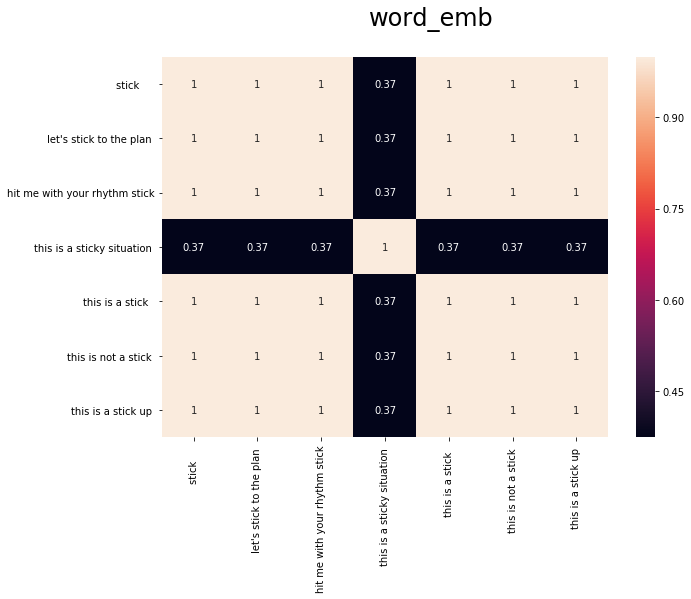

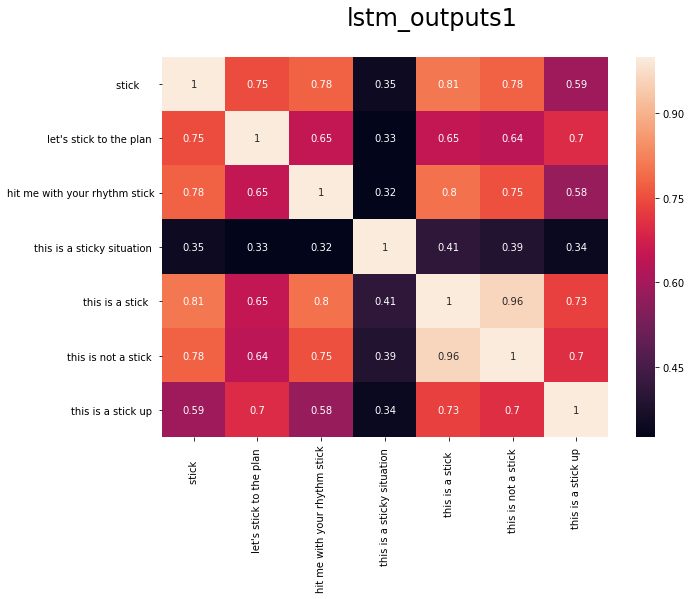

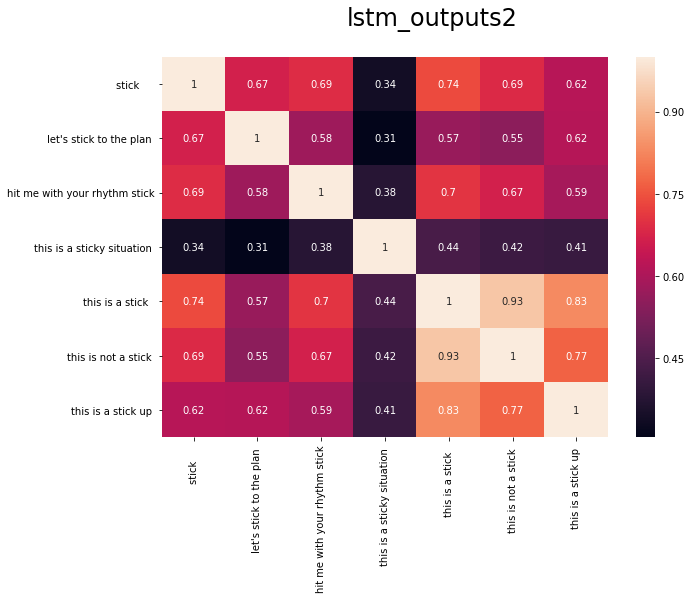

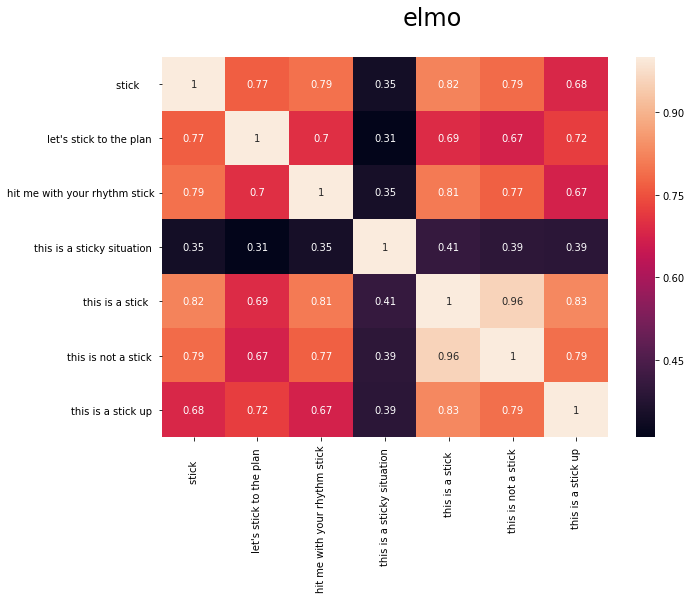

In [0]:
for elmo_layer in elmo_layers:
    sticks = []
    for i, sentence in enumerate(tokens_input):
        for j, word in enumerate(sentence):
            if word[:len("stick")] == "stick":
                sticks.append(result[elmo_layer][i][j])
                break
    plot_cosine_proximities(sticks, [" ".join([word for word in sentence]) for sentence in tokens_input], elmo_layer)

### Visualizar los embeddings para la misma palabra en frases distintras con ELMo

In [0]:
ejemplo = 'stick' #@param {type : 'string'}
correspondencia_exacta = True #@param {type : 'boolean'}
example_sentences = []
example_indices = []
sentences = []
for text in test_df['sentence'].tolist():
    sentences.extend(text.replace('!', '.').split('. '))
for sentence in sentences:
    words = sentence.split()
    for i, word in enumerate(words):
        if not correspondencia_exacta and ejemplo in word \
                or correspondencia_exacta and ejemplo == word:
            example_sentences.append((" ").join(words))
            example_indices.append(i)
            break
example_sentences = np.array(example_sentences, dtype=object)

In [0]:
# calcular los vectores correspondentes
batch_size = 32
result = {}
for batch in tqdm_notebook(range(len(example_sentences)//batch_size+1)):
    embeddings = elmo(
        inputs=example_sentences[batch * batch_size : batch * batch_size + batch_size],
        signature="default",
        as_dict=True) # "elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"
    sess.run(tf.global_variables_initializer())
    for elmo_layer in elmo_layers:
        matrix = sess.run(embeddings[elmo_layer])
        for i in range(matrix.shape[0]):
            example_index = example_indices[batch * batch_size + i]
            vector = np.transpose(np.expand_dims(matrix[i, example_index], axis=1))
            if elmo_layer in result:
                result[elmo_layer] = np.concatenate((result[elmo_layer], vector), axis=0)
            else:
                result[elmo_layer] = vector

In [0]:
# sacar un gráfico de t-SNE
elmo_layer = 'elmo' #@param ["elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"]
index_to_word = {}
for i, example_sentence in enumerate(example_sentences):
    index_to_word[i] = example_sentence
plot_tsne(embedding_matrix=result[elmo_layer], index_to_word=index_to_word, title=elmo_layer + ' t-SNE')

Loading BokehJS ...

### Definir una capa custom de Keras para ELMo

In [0]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self,
                 elmo_layer='elmo', # capa de embedding (o 'default' para el embedding de la frase)
                 max_len=512, # máximo número de tokens en las secuencias
                 **kwargs):
        assert elmo_layer in ['elmo', 'lstm_outputs1', 'lstm_outputs2', 'word_emb', 'default']
        self.elmo_layer = elmo_layer
        self.max_len = max_len
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))
        if self.trainable:
            # los cuatro parámetros que determinan la capa 'elmo' 
            self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                           as_dict=True,
                           signature='default')[self.elmo_layer]
        if self.elmo_layer != 'default':
            # hacer que las secuencias tengan el mismo tamaño
            result = K.concatenate(
                (K.zeros((K.cast(K.shape(result)[0], dtype='int32'),
                          K.constant(self.max_len, dtype='int32')-K.cast(K.shape(result)[1], dtype='int32'),
                          K.cast(K.shape(result)[2], dtype='int32'))), \
                 result),
                 axis=1)
        return result

    def compute_output_shape(self, input_shape):
        if self.elmo_layer == 'default':
            # embedding de la frase
            return (input_shape[0], self.elmo.get_output_info_dict()[elmo_layer].get_shape()[2].value)
        else:
            # embedding de las palabras
            return (input_shape[0], self.max_len, self.elmo.get_output_info_dict()[elmo_layer].get_shape()[2].value)

### Función para construir el modelo

In [0]:
def build_elmo_word_model(trainable=True, elmo_layer='elmo', max_len=512):
    input_text = Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer(elmo_layer=elmo_layer,
                                   trainable=trainable,
                                   max_len=max_len)(input_text)
    conv = Conv1D(256, 5, activation='relu')(embedding)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(15)(conv) # global max pooling
    flatten = Flatten()(conv)
    dense = Dense(256, activation='relu')(flatten)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def build_elmo_sentence_model(trainable=True):
    input_text = Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer(elmo_layer='default',
                                   trainable=trainable)(input_text)
    dense = Dense(256, activation='relu')(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

### Crear los conjuntos de datos

In [0]:
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:limite_de_palabras_en_la_secuencia]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:limite_de_palabras_en_la_secuencia]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()

### Construir el modelo

In [0]:
entrenable = True #@param {type : 'boolean'}
embedding_por_palabra = True #@param {type : 'boolean'}
elmo_layer = 'elmo' #@param ["elmo", "lstm_outputs1", "lstm_outputs2", "word_emb"]
if embedding_por_palabra:
    checkpoint_filename = '/ElmoWordModel.h5'
    elmo_model = build_elmo_word_model(trainable=entrenable, elmo_layer='elmo', max_len = limite_de_palabras_en_la_secuencia)
else:
    checkpoint_filename = '/ElmoSentenceModel.h5'
    elmo_model = build_elmo_sentence_model(trainable=entrenable)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 512, 1024)         4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 508, 256)          1310976   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 101, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 256)           327936    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 256)           327936    
__________

### Entrenar el modelo con un subconjunto de datos muy limitado

In [0]:
weights = elmo_model.get_weights()
numero_de_muestras = 1000 #@param {type : 'number'}
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')]
elmo_model.fit(train_text[:numero_de_muestras], 
               train_label[:numero_de_muestras],
               validation_data=(test_text[:numero_de_muestras], test_label[:numero_de_muestras]),
               epochs=20,
               batch_size=32 #@param {type : "number"}
               #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
               ,callbacks=callbacks)
elmo_model.set_weights(weights) # resetear el modelo

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 144s 144ms/step - loss: 0.7430 - acc: 0.5560 - val_loss: 0.5923 - val_acc: 0.6960
Epoch 2/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.5246 - acc: 0.7430 - val_loss: 0.5499 - val_acc: 0.7480
Epoch 3/20
1000/1000 [==============================] - 141s 141ms/step - loss: 0.3801 - acc: 0.8340 - val_loss: 0.4932 - val_acc: 0.7890
Epoch 4/20
1000/1000 [==============================] - 139s 139ms/step - loss: 0.2738 - acc: 0.8910 - val_loss: 0.4506 - val_acc: 0.8090
Epoch 5/20
1000/1000 [==============================] - 141s 141ms/step - loss: 0.2342 - acc: 0.9090 - val_loss: 0.5524 - val_acc: 0.7550
Epoch 6/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.1115 - acc: 0.9610 - val_loss: 0.6136 - val_acc: 0.8010
Epoch 7/20
1000/1000 [==============================] - 142s 142ms/step - loss: 0.0430 - acc: 0.9900 - val_loss: 0.6477 - va

### Entrenar con todos los datos de IMDB (fine-tuning)

In [0]:
#elmo_model.load_weights(checkpoint_dir + checkpoint_filename)
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
             ModelCheckpoint(checkpoint_dir + checkpoint_filename, save_best_only=True, monitor='val_loss', mode='min')]
elmo_model.fit(train_text, 
               train_label,
               validation_data=(test_text, test_label),
               epochs=20,
               batch_size=32 #@param {type : 'number'}
               #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
               ,callbacks=callbacks)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3246s 130ms/step - loss: 0.3602 - acc: 0.8409 - val_loss: 0.2672 - val_acc: 0.8904
Epoch 2/20
25000/25000 [==============================] - 3192s 128ms/step - loss: 0.2472 - acc: 0.9002 - val_loss: 0.2640 - val_acc: 0.8952
Epoch 3/20
25000/25000 [==============================] - 3208s 128ms/step - loss: 0.1913 - acc: 0.9243 - val_loss: 0.2602 - val_acc: 0.9002
Epoch 4/20
25000/25000 [==============================] - 3199s 128ms/step - loss: 0.1406 - acc: 0.9463 - val_loss: 0.2777 - val_acc: 0.9032
Epoch 5/20
25000/25000 [==============================] - 3195s 128ms/step - loss: 0.0945 - acc: 0.9648 - val_loss: 0.3171 - val_acc: 0.8942
Epoch 6/20
25000/25000 [==============================] - 3183s 127ms/step - loss: 0.0728 - acc: 0.9737 - val_loss: 0.3545 - val_acc: 0.8924


In [0]:
# ver output de la capa de embedding
test = np.expand_dims(np.array(['hi there fans']), axis=0)
K.function([elmo_model.input, K.learning_phase()], [elmo_model.layers[1].output])([test, 1.])

[array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.2897265 ,  0.04342684, -0.13304959, ..., -0.3292536 ,
           0.10790168, -0.18136144],
         [ 0.19243096, -0.18765599, -0.05203546, ...,  0.49453145,
          -0.07940593, -0.21373391],
         [-0.17233269, -0.30347633,  0.09974478, ...,  0.4113018 ,
           0.14885364,  0.11624762]]], dtype=float32)]

In [0]:
# los pesos asignados a los embeddings después del entrenamiento
K.get_session().run(elmo_model.trainable_weights[0])

array([ 0.24009205,  0.55799705, -0.5203339 ], dtype=float32)

In [0]:
# el factor de escalado después del entrenamiento
K.get_session().run(elmo_model.trainable_weights[1])

0.88082606

### Validar un modelo que ya hemos entrenado

In [0]:
numero_de_muestras = 25000 #@param {type : 'number'}
elmo_model.load_weights(checkpoint_dir + checkpoint_filename)
threshold = 0.5 #@param {type : "number", min : 0, max : 1}
test_pred = elmo_model.predict(test_text[:numero_de_muestras])
matrix = confusion_matrix(test_label[:numero_de_muestras], test_pred >= threshold)

In [0]:
print(f'val_acc {100 * np.trace(matrix)/np.sum(matrix):.2f}%')
print('Confusion matrix')
print(matrix)

val_acc 90.01%
Confusion matrix
[[11055  1445]
 [ 1053 11447]]


In [0]:
false_negatives = [_ for _ in range(numero_de_muestras) if test_label[_] and test_pred[_] < threshold]
false_positives = [_ for _ in range(numero_de_muestras) if not test_label[_] and test_pred[_] >= threshold]

In [0]:
print('False negatives')
for sample in np.random.choice(false_negatives, 10, replace=False):
    print(f'[{float(test_pred[sample]):.2f}] {test_text[sample][0]}')
print()
print('False positives')
for sample in np.random.choice(false_positives, 10, replace=False):
    print(f'[{float(test_pred[sample]):.2f}] {test_text[sample][0]}')

False negatives
[0.40] The movie starts with a board meeting at a major advertising agency. Putney Swope is on the board for no other reason than the fact that he is black, and the agency needs a "token" on the board. Swope is ignoring the meeting, reading Jet magazine at the big table, and everybody is ignoring Swope... Suddenly, the CEO croaks on the spot. No time is wasted. A janitor is called to haul off the corpse, and the board immediately and unceremoniously tackles the business of electing a new CEO. And as the votes are tallied one by one, the tension is built up and then finally snapped in a hilariously ironic climax to the vote, that gives the viewer a delicious dish of logical implications to savor for the rest of the movie. If you've ever talked back to some stupid television commercial, you'll like seeing this movie. Too bad there don't seem to be any real Putney Swopes in the world.
[0.39] Before I saw this film I didn't really expect to much from it, although my friend 

<p><img width="90px" src="https://vignette.wikia.nocookie.net/puppet/images/9/9c/Bert2000%27s.jpg/revision/latest?cb=20101221030132" align="left" hspace="10px" vspace="0px"></p>

# BERT - Bidirectional Encoder Representations for Transformers

[Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

[GitHub](https://github.com/google-research/bert)

[TensorFlow Hub](https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1)

### Descargar el modelo de BERT de Tensorflow Hub

In [0]:
modelo_de_bert = 'bert_uncased_L-12_H-768_A-12/1' #@param ["bert_uncased_L-12_H-768_A-12/1", "bert_cased_L-12_H-768_A-12/1", "bert_uncased_L-24_H-1024_A-16/1", "bert_cased_L-24_H-1024_A-16/1", "bert_multi_cased_L-12_H-768_A-12/1"]
bert = hub.Module('https://tfhub.dev/google/' + modelo_de_bert)

# instanciar el tokenizador
tokenization_info = bert(signature='tokenization_info', as_dict=True)
vocab_file, do_lower_case = sess.run([tokenization_info['vocab_file'], tokenization_info['do_lower_case'],])
tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

### Veamos un ejemplo de cómo usar BERT

In [0]:
#tokenizer.tokenize("This here's an example of using the BERT tokenizer")
tokenizer.tokenize("Esto es un ejemplo de cómo usar el tokenizador de BERT")

['est',
 '##o',
 'es',
 'un',
 'e',
 '##je',
 '##mp',
 '##lo',
 'de',
 'como',
 'usa',
 '##r',
 'el',
 'token',
 '##iza',
 '##dor',
 'de',
 'bert']

In [0]:
# tokenizar e incluir los tokens [CLS] para "CLaSificar" (pooled_output) y [SEP] para separar las frases
tokens_input = ['[CLS]'] + tokenizer.tokenize("let's stick to the plan") + ['[SEP]']
input_ids = np.expand_dims(np.array(tokenizer.convert_tokens_to_ids(tokens_input)), axis=0)

# sin máscara (=1)
input_mask = np.ones(input_ids.shape)

# identificar las frases (segmentos): aquí sólo tenemos una
segment_ids = np.zeros(input_ids.shape)

# instanciar el modelo
bert_model = bert(dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids), signature="tokens", as_dict=True)
sess.run(tf.global_variables_initializer())

# ponemos sequence_output para obtener los embeddings por palabra y pooled_output para obtener un embedding por frase
result = sess.run(bert_model['sequence_output'])

In [0]:
result

array([[[ 0.33146906, -0.12789875,  0.01895166, ..., -0.03692069,
          0.15176263,  0.42075813],
        [ 1.5566795 , -0.08537437, -0.82845265, ...,  0.8276861 ,
          0.64441293,  0.26434293],
        [ 1.1136397 ,  0.10624526,  0.42074698, ...,  0.5653447 ,
         -0.82294077, -0.42941973],
        ...,
        [-0.03414882, -1.1695514 , -0.15654358, ...,  0.24314603,
          0.05139303,  0.51760143],
        [ 0.468054  , -0.3679177 , -0.5233744 , ...,  0.06581204,
         -0.27941722,  0.07135601],
        [ 1.0049226 ,  0.03354119, -0.23236203, ...,  0.04083146,
         -0.52917576, -0.4445621 ]]], dtype=float32)

In [0]:
result.shape

(1, 9, 768)

### Visualizar los embeddings para la misma palabra en frases distintras con BERT

In [0]:
# calcular los vectores correspondentes
batch_size = 32
result = None
example_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ejemplo))[0]
for batch in tqdm_notebook(range(len(example_sentences)//batch_size+1)):
    input_ids = []
    example_indices = []
    for example_sentence in example_sentences[batch * batch_size : batch * batch_size + batch_size]:
        tokens_input = ['[CLS]'] + tokenizer.tokenize(example_sentence) + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens_input[:limite_de_palabras_en_la_secuencia])
        ids = ids + [0] * (limite_de_palabras_en_la_secuencia - len(ids))
        example_index = None
        for i, id in enumerate(ids):
            if id == example_id:
                example_index = i
                break
        input_ids.append(ids)
        example_indices.append(example_index)
    input_ids = np.array(input_ids)
    input_mask = np.ones(input_ids.shape)
    segment_ids = np.zeros(input_ids.shape)
    bert_model = bert(dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids), signature='tokens', as_dict=True)
    sess.run(tf.global_variables_initializer())
    matrix = sess.run(bert_model['sequence_output'])
    for i in range(matrix.shape[0]):
        if example_indices[i] is None:
            continue
        vector = np.transpose(np.expand_dims(matrix[i, example_indices[i]], axis=1))
        if result is not None:
            result = np.concatenate((result, vector), axis=0)
        else:
            result = vector

In [0]:
# sacar un gráfico de t-SNE
index_to_word = {}
for i, example_sentence in enumerate(example_sentences):
    index_to_word[i] = example_sentence
plot_tsne(embedding_matrix=result, index_to_word=index_to_word, title='BERT t-SNE')

Loading BokehJS ...

### Definir una capa custom de Keras para BERT

In [0]:
class BertEmbeddingLayer(Layer):
    def __init__(self,
                 output_key='sequence_output', # 'sequence_output': embedding de las palabras, 'pooled_ouput': embedding de la frase
                 n_fine_tune_layers=0, # número de capas a entrenar (sin contar la de pooling)
                 bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1", # modelo de BERT preentrenado
                 max_len=512, # número máximo de tokens en las secuencias
                 **kwargs):
        assert output_key == 'sequence_output' or output_key == 'pooled_output'
        self.output_key = output_key
        self.n_fine_tune_layers = n_fine_tune_layers
        self.bert_path = bert_path
        self.max_len = max_len
        super(BertEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(self.bert_path, trainable=self.trainable, name="{}_module".format(self.name))
        if self.trainable:
            if self.output_key == 'pooled_output':
                # añadir las variables de la capa de pooling a las que vammos a entrenar
                self.trainable_weights += [var for var in self.bert.variables
                                           if 'pooler/' in var.name]
            # añadir las variables de las últimas n capas a las que vamos a entrenar
            top_layer = max([int(_[_.find('layer_'):][6:_[_.find('layer_'):].find('/')])
                             for _ in [var.name for var in bert.variables
                                       if 'layer_' in var.name]])
            self.trainable_weights += [var for var in self.bert.variables
                                       if any([f'layer_{top_layer-i}/' in var.name
                                               for i in range(self.n_fine_tune_layers)])]
            self.non_trainable_weights += [var for var in self.bert.variables
                                           if var not in self.trainable_weights]
        super(BertEmbeddingLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype='int32') for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
        result = self.bert(inputs=bert_inputs, signature='tokens', as_dict=True)[self.output_key]
        return result

    def compute_output_shape(self, input_shape):
        if self.output_key == 'pooled_output':
            # embedding de la frase
            return (input_shape[0], self.bert.get_output_info_dict('tokens')[self.output_key].get_shape()[1].value)
        else:
            # embedding de las palabras
            return (input_shape[0], self.max_len, self.bert.get_output_info_dict('tokens')[self.output_key].get_shape()[2].value)

### Función para construir el modelo

In [0]:
def build_bert_word_model(trainable=True, n_fine_tune_layers=10,
                          bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
                          max_len=limite_de_palabras_en_la_secuencia):
    in_id = Input(shape=(max_len,), name="input_ids")
    in_mask = Input(shape=(max_len,), name="input_masks")
    in_segment = Input(shape=(max_len,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    embedding = BertEmbeddingLayer(trainable=trainable,
                                   output_key='sequence_output',
                                   n_fine_tune_layers=n_fine_tune_layers,
                                   bert_path=bert_path,
                                   max_len=max_len)(bert_inputs)
    conv = Conv1D(256, 5, activation='relu')(embedding)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(5)(conv)
    conv = Conv1D(256, 5, activation='relu')(conv)
    conv = MaxPooling1D(15)(conv) # global max pooling
    flatten = Flatten()(conv)
    dense = Dense(256, activation='relu')(flatten)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

def build_bert_sentence_model(trainable=True, n_fine_tune_layers=10,
                              bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
                              max_len=limite_de_palabras_en_la_secuencia):
    in_id = Input(shape=(max_len,), name="input_ids")
    in_mask = Input(shape=(max_len,), name="input_masks")
    in_segment = Input(shape=(max_len,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    embedding = BertEmbeddingLayer(trainable=trainable,
                                   output_key='pooled_output',
                                   n_fine_tune_layers=n_fine_tune_layers,
                                   bert_path=bert_path,
                                   max_len=max_len)(bert_inputs)
    dense = Dense(256, activation='relu')(embedding)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

### Tokenizar y crear los demás inputs (máscara, segmento y etiqueta) para BERT

In [0]:
train_examples = train_df['sentence'].tolist()
train_examples = [['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'] for t in tqdm_notebook(train_examples, desc='tokenizing')]
train_examples = [tokenizer.convert_tokens_to_ids(t[:limite_de_palabras_en_la_secuencia]) for t in train_examples]
train_mask = [[1] * len(_) for _ in train_examples]
train_examples = sequence.pad_sequences(train_examples, maxlen=limite_de_palabras_en_la_secuencia, padding='post')
train_mask = sequence.pad_sequences(train_mask, maxlen=limite_de_palabras_en_la_secuencia, padding='post')
train_segment = np.zeros(train_examples.shape)
train_label = train_df['polarity'].tolist()

test_examples = test_df['sentence'].tolist()
test_examples = [['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'] for t in tqdm_notebook(test_examples, desc='tokenizing')]
test_examples = [tokenizer.convert_tokens_to_ids(t[:limite_de_palabras_en_la_secuencia]) for t in test_examples]
test_mask = [[1] * len(_) for _ in test_examples]
test_examples = sequence.pad_sequences(test_examples, maxlen=limite_de_palabras_en_la_secuencia, padding='post')
test_mask = sequence.pad_sequences(test_mask, maxlen=limite_de_palabras_en_la_secuencia, padding='post')
test_mask = np.ones(test_examples.shape)
test_segment = np.ones(test_examples.shape)
test_label = test_df['polarity'].tolist()

### Construir el modelo

In [0]:
entrenable = False #@param {type : 'boolean'}
numero_de_capas_a_tunear = 0 #@param {type: 'slider', min : 0, max : 24}
embedding_por_palabra = True #@param {type : 'boolean'}
if embedding_por_palabra:
    checkpoint_filename = '/BertWordModel.h5'
    bert_model = build_bert_word_model(trainable=entrenable, n_fine_tune_layers=numero_de_capas_a_tunear, bert_path='https://tfhub.dev/google/' + modelo_de_bert, max_len=limite_de_palabras_en_la_secuencia)
else:
    checkpoint_filename = '/BertSentenceModel.h5'
    bert_model = build_bert_sentence_model(trainable=entrenable, n_fine_tune_layers=numero_de_capas_a_tunear, bert_path='https://tfhub.dev/google/' + modelo_de_bert, max_len=limite_de_palabras_en_la_secuencia)

W0718 11:07:17.149657 140559068313472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 11:07:17.163361 140559068313472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 11:07:20.803047 140559068313472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 11:07:20.830857 140559068313472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0718 11:07:20.921607 140559068313472 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 512)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
bert_embedding_layer_1 (BertEmb ((None, 512), 512, 7 0           input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

### Entrenar el modelo con un subconjunto de datos muy limitado

In [0]:
weights = bert_model.get_weights()
numero_de_muestras = 1000 #@param {type : 'number'}
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')]
bert_model.fit([train_examples[:numero_de_muestras], train_mask[:numero_de_muestras], train_segment[:numero_de_muestras]],
               train_label[:numero_de_muestras],
               validation_data=([test_examples[:numero_de_muestras], test_mask[:numero_de_muestras], test_segment[:numero_de_muestras]], test_label[:numero_de_muestras]),
               epochs=40,
               batch_size=32 #@param {type : "number"}
               #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
               ,callbacks=callbacks)
bert_model.set_weights(weights) # resetear el modelo

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 166s 166ms/step - loss: 0.7576 - acc: 0.5390 - val_loss: 0.6924 - val_acc: 0.5170
Epoch 2/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.5061 - acc: 0.7640 - val_loss: 0.6331 - val_acc: 0.6500
Epoch 3/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.3394 - acc: 0.8510 - val_loss: 1.1477 - val_acc: 0.5770
Epoch 4/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.2408 - acc: 0.9030 - val_loss: 0.8085 - val_acc: 0.7000
Epoch 5/20
1000/1000 [==============================] - 159s 159ms/step - loss: 0.1835 - acc: 0.9260 - val_loss: 2.3546 - val_acc: 0.5350


### Entrenar con todos los datos de IMDB (fine-tuning)

In [0]:
bert_model.load_weights(checkpoint_dir + checkpoint_filename)
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min'),
             ModelCheckpoint(checkpoint_dir + checkpoint_filename, save_best_only=True, monitor='val_loss', mode='min')]
bert_model.fit([train_examples, train_mask, train_segment],
               train_label,
               validation_data=([test_examples, test_mask, test_segment], test_label),
               epochs=20,
               batch_size=32 #@param {type : "number"}
               #@markdown La memoría utilizada por el GPU depende del tamaño del batch y el número de palabras en  las sequencias
               ,callbacks=callbacks)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3979s 159ms/step - loss: 0.1780 - acc: 0.9304 - val_loss: 0.2707 - val_acc: 0.8899
Epoch 2/20
25000/25000 [==============================] - 3979s 159ms/step - loss: 0.1364 - acc: 0.9477 - val_loss: 0.3616 - val_acc: 0.8528
Epoch 3/20
25000/25000 [==============================] - 3981s 159ms/step - loss: 0.1028 - acc: 0.9616 - val_loss: 0.3588 - val_acc: 0.8778
Epoch 4/20
 5024/25000 [=====>........................] - ETA: 26:27 - loss: 0.0831 - acc: 0.9680

### Validar un modelo que ya hemos entrenado

In [0]:
numero_de_muestras = 25000 #@param {type : 'number'}
bert_model.load_weights(checkpoint_dir + checkpoint_filename)
threshold = 0.5 #@param {type : "number", min : 0, max : 1}
test_pred = bert_model.predict([test_examples[:numero_de_muestras], test_mask[:numero_de_muestras], test_segment[:numero_de_muestras]])
matrix = confusion_matrix(test_label[:numero_de_muestras], test_pred >= threshold)

In [0]:
print(f'val_acc {100 * np.trace(matrix)/np.sum(matrix):.2f}%')
print('Confusion matrix')
print(matrix)

val_acc 88.99%
Confusion matrix
[[11678   822]
 [ 1930 10570]]


In [0]:
false_negatives = [_ for _ in range(numero_de_muestras) if test_label[_] and test_pred[_] < threshold]
false_positives = [_ for _ in range(numero_de_muestras) if not test_label[_] and test_pred[_] >= threshold]

In [0]:
print('False negatives')
for sample in np.random.choice(false_negatives, 10, replace=False):
    print(f'[{float(test_pred[sample]):.2f}] {test_df["sentence"].tolist()[sample]}')
print()
print('False positives')
for sample in np.random.choice(false_positives, 10, replace=False):
     print(f'[{float(test_pred[sample]):.2f}] {test_df["sentence"].tolist()[sample]}')

False negatives
[0.01] A very strange, disturbing but intriguing film. I don't think I ever needed to see what a human being can do with his butt, and I doubt if I'll ever want to see it again. That said, there is much to be amused by, like Divine's take on Jayne Mansfield's classic walk in "The Girl Can't Help It" and putting slabs of meat between her legs in a grocery store. A gritty feel very much like a Russ Meyer film. Generally poor acting, with the notable exception of Divine.
[0.27] Harrowing series about life in Oz--an experimental prison where they try to rehabilitate prisoners. There's gay sex, rape, torture, mutilation, killings, humiliation, tons of male nudity...all in your face and going full force.<br /><br />It also is easily one of the best written dramas ever put on TV and almost all the actors are just great. Since this was on cable there were no restrictions on what they could say or show. There's plenty of racist comments flying in here but it's for all races. In 

### Algunas conclusiones

El modelo de BERT pre-entrenado es muy efectivo con pocos datos de entrenamiento. Limitando los datos de IMDB a 1,000 muestras de entrenamiento y 1,000 muestras de validación, acertamos con 87% de los datos de validación con el modelo "pequeño" de BERT y los embeddings por palabra (frente a 81% con ELMo y 70% con GloVe). Al ser un modelo mucho más grande que ELMo (336 millones de parámeteros del modelo grande de BERT versus los 13,6 millones del modelo de ELMo*), necesitamos muchos más datoos de entrenamiento si queremos obtener un buen resultado entrenando las capas de BERT ("fine-tuning"). Según https://paperswithcode.com/sota/sentiment-analysis-on-imdb, BERT ha conseguido una nota de 95.8% aplicando técnicas de aumentación de datos.

\* Es posible descargar modelos de ELMo pre-entrenados más grandes aquí: https://allennlp.org/elmo, pero, aún así, en el mayor de los casos cuentan con "sólo" 93,6 millones de parámetros.

<p><img width="90px" src="https://cdn.vox-cdn.com/thumbor/JFmmLp25gpvP7kbRZU-PigUz-mA=/0x94:1494x1090/920x613/filters:focal(0x94:1494x1090):format(webp)/cdn.vox-cdn.com/uploads/chorus_image/image/45686844/big_bird_half.0.0.jpg" align="left" hspace="10px" vspace="0px"></p>

# XLNet - Transformer-XL Network

[XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://arxiv.org/abs/1906.08237)

[GitHub](https://github.com/zihangdai/xlnet)

### Instalar el modelo, descargar los datos (otra vez) y los checkpoints

In [0]:
!pip install sentencepiece
!git clone https://github.com/zihangdai/xlnet.git
%cd xlnet
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar zxf aclImdb_v1.tar.gz
!wget https://storage.googleapis.com/xlnet/released_models/cased_L-24_H-1024_A-16.zip
!unzip cased_L-24_H-1024_A-16.zip
!rm aclImdb_v1.tar.gz
!rm cased_L-24_H-1024_A-16.zip

     |████████████████████████████████| 1.0MB 9.4MB/s 
Cloning into 'xlnet'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 107 (delta 3), reused 5 (delta 1), pack-reused 94
Receiving objects: 100% (107/107), 143.88 KiB | 779.00 KiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/xlnet
--2019-07-01 08:00:07--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  18.6MB/s    in 6.2s    

2019-07-01 08:00:14 (12.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

--2019-07-01 08:00:22--  https://storage.googleapis.com/xlnet/released_models/cased_L-24_H

### Entrenar con los datos de IMDB (fine-tuning)





In [0]:
command = 'python run_classifier.py \
  --use_tpu=False \
  --do_train=True \
  --do_eval=True \
  --eval_all_ckpt=False \
  --task_name=imdb \
  --data_dir=aclImdb \
  --output_dir=./proc_data/imdb \
  --model_dir='"+checkpoint_dir+"/xlnet' \
  --uncased=False \
  --spiece_model_file=./xlnet_cased_L-24_H-1024_A-16/spiece.model \
  --model_config_path=./xlnet_cased_L-24_H-1024_A-16/xlnet_config.json \
  --init_checkpoint=./xlnet_cased_L-24_H-1024_A-16/xlnet_model.ckpt \
  --max_seq_length=512 \
  --train_batch_size=1 \
  --eval_batch_size=1 \
  --num_hosts=1 \
  --num_core_per_host=1 \
  --learning_rate=2e-5 \
  --train_steps=4000 \
  --warmup_steps=500 \
  --save_steps=500 \
  --iterations=500 \
'
!{command}

W0630 21:04:45.718999 139666540828544 deprecation_wrapper.py:119] From /content/xlnet/model_utils.py:295: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0630 21:04:45.721568 139666540828544 deprecation_wrapper.py:119] From run_classifier.py:855: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0630 21:04:45.722225 139666540828544 deprecation_wrapper.py:119] From run_classifier.py:637: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0630 21:04:45.722380 139666540828544 deprecation_wrapper.py:119] From run_classifier.py:637: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0630 21:04:45.722510 139666540828544 deprecation_wrapper.py:119] From run_classifier.py:661: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0630 21:04:45.781007 139666540828544 deprecation_wrapper.py:119] From /cont

### Validar un modelo que ya hemos entrenado



In [0]:
!rm -rf proc_data/*
command = 'python run_classifier.py \
  --use_tpu=False \
  --do_predict=True \
  --predict_dir="'+checkpoint_dir+'/xlnet" \
  --task_name=imdb \
  --data_dir=aclImdb \
  --output_dir=./proc_data/imdb \
  --model_dir='"+checkpoint_dir+"/xlnet' \
  --uncased=False \
  --spiece_model_file=./xlnet_cased_L-24_H-1024_A-16/spiece.model \
  --model_config_path=./xlnet_cased_L-24_H-1024_A-16/xlnet_config.json \
  --init_checkpoint="'+checkpoint_dir+'/xlnet/model.ckpt-4000" \
  --max_seq_length=512 \
  --eval_batch_size=1 \
  --predict_batch_size=1 \
'
!{command}

W0630 16:07:41.021502 140435082413952 deprecation_wrapper.py:119] From /content/xlnet/model_utils.py:295: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0630 16:07:41.024010 140435082413952 deprecation_wrapper.py:119] From run_classifier.py:855: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0630 16:07:41.024595 140435082413952 deprecation_wrapper.py:119] From run_classifier.py:637: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0630 16:07:41.024730 140435082413952 deprecation_wrapper.py:119] From run_classifier.py:637: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0630 16:07:41.024825 140435082413952 deprecation_wrapper.py:119] From run_classifier.py:645: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0630 16:07:41.025829 140435082413952 deprecation_wrapper.py:119] From run_c

In [0]:
with open(checkpoint_dir + '/xlnet/imdb.logits.json', 'r') as f:
    results = json.load(f)
classifications = pd.DataFrame.from_csv(checkpoint_dir + '/xlnet/imdb.tsv', sep='\t')
false_pos = []
directory = 'aclImdb/test/neg'
num_neg = len(os.listdir(directory))
for i, filename in enumerate(os.listdir(directory)):
    if classifications['prediction'][i] == 'pos':
        with open(os.path.join(directory, filename), 'r') as file:
            text = " ".join(file.readline().split()[:limite_de_palabras_en_la_secuencia])
        false_pos.append((text, np.exp(results[i][1]) / np.sum(np.exp(results[i]), axis=0)))
false_neg = []
directory = 'aclImdb/test/pos'
num_pos = len(os.listdir(directory))
for i, filename in enumerate(os.listdir(directory)):
    if classifications['prediction'][i+num_neg] == 'neg':
        with open(os.path.join(directory, filename), 'r') as file:
            text = " ".join(file.readline().split()[:limite_de_palabras_en_la_secuencia])
        false_neg.append((text, np.exp(results[i+num_neg][1]) / np.sum(np.exp(results[i+num_neg]), axis=0)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
print(f'val_acc {1-(len(false_neg) + len(false_pos))/(num_neg + num_pos):.4f}')
matrix = np.array([[num_neg, len(false_pos)], [len(false_neg), num_pos]])
print('Confusion matrix')
print(matrix)

val_acc 0.9452
Confusion matrix
[[12500   773]
 [  596 12500]]


In [0]:
print('False negatives')
random_indices = np.random.choice(range(len(false_neg)), 10, replace=False)
for i in random_indices:
    print(f'[{float(false_neg[i][1]):.2f}] {false_neg[i][0]}')
print()
print('False positives')
random_indices = np.random.choice(range(len(false_pos)), 10, replace=False)
for i in random_indices:
    print(f'[{float(false_pos[i][1]):.2f}] {false_pos[i][0]}')


False negatives
[0.07] Whether you're a fan of the series which inspired it or not, there's no denying this is a patchy piece of work. But in the best possible sense. Keen to get away from the trappings of old sitcoms which made an uneasy transition to the big screen, Messrs Pemberton, Dyson, Shearmsith and Gatiss have gone down a different road, addressing the problems of dealing with their success along with adding other creations and, inevitably, rehashing some of their best-loved characters. It's a pity they didn't stick to just a more consistent League of Gents movie because as inventive as including themselves in the screenplay is, it weakens the finished movie. Well worth renting though.
[0.00] If there were two parts that the physically towering, ugly-charismatic actor Gérard Depardieu was born, as a Frenchman, to play, it must surely have been Cyrano de Bergerac and the orator Georges Danton. Here he dominates the film both through the breadth of his shoulders and the power of